## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [209]:
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

We have imported all the required libraries. Next, we will define a Q_state function that joins all the states into a string representation.

In [170]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [171]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

Lets see the actions the agent is allowed to take for a particular state of the Tictactoe game.

In [172]:
print(valid_actions([7, np.nan, np.nan, 1, 2, 8, np.nan, np.nan, np.nan]))

[(1, 3), (1, 5), (1, 9), (2, 3), (2, 5), (2, 9), (6, 3), (6, 5), (6, 9), (7, 3), (7, 5), (7, 9), (8, 3), (8, 5), (8, 9)]


In [173]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

## Epsilon-greedy strategy 

We have defined our custom epsilon decay strategy. For this, we start with a max epsilon value and then for each time step we multiply the epsilon with a decay factor which effectively reduces the epsilon value gradually. The decay graph is shown at the end of the notebook.

The agent initially prefers the exploration strategy but gradually moves to exploitation.

In [174]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, epsilon_value):
    #epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    z = np.random.random()
    
    q_state = Q_state(state)
        
    if z > epsilon_value:
        #print('greedy')
        action = max(Q_dict[q_state],key=Q_dict[q_state].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        #print('non-greedy')
        possible_actions = valid_actions(state)
        pos = np.random.randint(len(possible_actions))
        action = valid_actions(state)[pos]        #Exploration: randomly choosing an action  
    
    return action



#### Tracking the state-action pairs for checking convergence - write your code here

In [175]:
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

print(len(Q_dict))
print(len(States_track))

0
0


**Due to limited computing resource I have chosen 4 states of the board (for tracking) and 4 corresponding actions for which the agent would win the game in the next state. If the Q-learning converges then we will see that the Q values for these states would gradually increase as the agent gradually learns that these states and their corresponding actions are most favourable.**

In [176]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('3-1-x-x-7-4-x-8-6', (2, 5)),('3-x-6-x-4-x-x-x-7',(6, 5)), ('x-x-8-3-9-x-x-x-2',(5,5)),('x-1-x-3-x-2-x-x-4',(2,9))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

In [177]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [178]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [179]:
initialise_tracking_states()

## Define hyperparameters 

I will run 3 million episodes and saved the Q values in intervals of 50,000 episodes. Also, I am using epsilon decay strategy that will make the agent gradually shift from exploration to exploitation. Furthermore, I have chosen different values of LR and GAMMA based on my experimentation.

In [182]:
EPISODES = 3000000
LR = 0.05                   #learning rate
GAMMA = 0.91
threshold = 50000
epsilon = 0.4
decay = 0.8

### Q-update loop ---write your code here

In [183]:
import copy 

start_time = time.time()
reward = 0

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    #print('Running episode ',episode)
    env = TicTacToe()
    epsilon_value = epsilon
    # preserve the current state for updating its Q value
    curr_state = copy.deepcopy(env.state)
    
    # add initial state to Q_dict
    add_to_dict(curr_state)
    total_reward = 0
    
    # done is true if the game finishes
    done = False
    while not done:
        
        # The next action for the agent is picked based on the epsilon_greedy strategy
        curr_action = epsilon_greedy(env.state,epsilon_value)
        
        # The next state, reward and game completion is obtained from the environment using
        # the step function
        next_state, reward, done = env.step(copy.deepcopy(curr_state), curr_action)
        
        # add the next state to the dictionary.
        add_to_dict(next_state)
        
        next_q_state = Q_state(next_state)
        curr_q_state = Q_state(curr_state)
        #print('curr_q_state ',curr_q_state)
        #print('curr_action',curr_action)
        #print('next_q_state ',next_q_state)
        
        if not done:
            # if the game is still on, we update the Q value of the current state based on 
            # the next state and the Q value update equation
            
            max_next = max(Q_dict[next_q_state],key=Q_dict[next_q_state].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[curr_q_state][curr_action] += \
            LR * ((reward + (GAMMA*(Q_dict[next_q_state][max_next]))) - \
                  Q_dict[curr_q_state][curr_action] )
        else:
            # if the game is over, we update the Q value of the current state considering that
            # the Q value of the next state is 0 as there can be no actions possible in the next state.
            
            Q_dict[curr_q_state][curr_action] += \
            LR * (reward - Q_dict[curr_q_state][curr_action] )
            #print('reward ',reward)
            #print('Q-value ',Q_dict[curr_q_state][curr_action])

        # The new state becomes the current state for the next iteration
        curr_state = copy.deepcopy(next_state)

        # calculate the total reward the agent has got till now for this episode of the game.
        total_reward += reward
        
        # epsilon value is decayed over a period of time
        epsilon_value = epsilon_value*decay
    
    #TRACKING Q-VALUES
    # save the tracked state action pair Q values in intervals   
    if ((episode+1) % threshold) == 0:
        #print('saving tracking')
        save_tracking_states()
        save_obj(States_track,'States_tracked') 
    
    
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print(episode)

Total time taken  2486.313222885132
2999999


#### Check the Q-dictionary

In [184]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 2.804367587298472,
              (0, 3): 2.0090351644557605,
              (0, 5): 2.959801788962028,
              (0, 7): 2.7744086950117004,
              (0, 9): 2.332921090590137,
              (1, 1): 1.841026579021764,
              (1, 3): 2.488124008577458,
              (1, 5): 2.823235385859625,
              (1, 7): 3.061573342254134,
              (1, 9): 3.022274564373851,
              (2, 1): 4.782608816482847,
              (2, 3): 2.8423956215039032,
              (2, 5): 3.7153905454595173,
              (2, 7): 1.9771198334706845,
              (2, 9): 3.4730122671390187,
              (3, 1): 3.5868595054779315,
              (3, 3): 3.0873837068317624,
              (3, 5): 4.344067801758475,
              (3, 7): 3.0474144615780934,
              (3, 9): 3.7082294524383856,
              (4, 1): 3.766057021222539,
              (4, 3): 1.573322516356929,
              (4, 5): 2.467132583065533,
        

In [185]:
len(Q_dict)

1683040

In [186]:
total_reward

7

In [187]:
States_track

defaultdict(dict,
            {'3-1-x-x-7-4-x-8-6': {(2, 5): []},
             '3-x-6-x-4-x-x-x-7': {(6, 5): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0.5,
               0.9750000000000001,
               0.9750000000000001,
               1.42625,
               1.42625,
               1.42625,
               1.42625,
               1.42625,
           

In [188]:
Q_dict['x-x-8-3-9-x-x-x-2']

{(0, 1): -0.05,
 (0, 5): -0.05,
 (0, 7): -0.05,
 (1, 1): -0.05,
 (1, 5): -0.05,
 (1, 7): -0.05,
 (5, 1): -0.05,
 (5, 5): 0,
 (5, 7): 0,
 (6, 1): 0,
 (6, 5): -0.05,
 (6, 7): 0,
 (7, 1): -0.05,
 (7, 5): -0.5,
 (7, 7): 0}

In [189]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['3-x-6-x-4-x-x-x-7'][(6, 5)]

1.8549375000000001

### Check the states tracked for Q-values convergence
(non-evaluative)

We will take a few example tracked states to see if the Q values have converged.

In [190]:
# Write the code for plotting the graphs for state-action pairs tracked

In [193]:
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)  

In [194]:
States_track['3-x-6-x-4-x-x-x-7'][(6, 5)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0.9750000000000001,
 0.9750000000000001,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.42625,
 1.8549375000000001]

## Plots

We will plot two of the tracked state-action pair Q values. The expectation is that the Q-values will increase gradually over time as the agent slowly learns that these states are particularly good as they lead to immediate win for the agent in the next state.

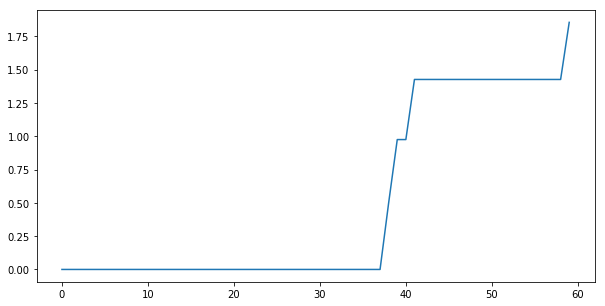

In [203]:
#xaxis = np.asarray(range(0, 4))
xaxis = np.arange(len(States_track['3-x-6-x-4-x-x-x-7'][(6, 5)]))
plt.figure(0, figsize=(10,5))

plt.plot(xaxis,np.array(States_track['3-x-6-x-4-x-x-x-7'][(6, 5)]))
plt.show()

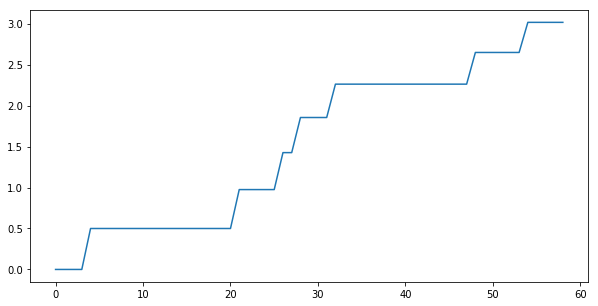

In [205]:
#xaxis = np.asarray(range(0, 4))
xaxis = np.arange(len(States_track['x-1-x-3-x-2-x-x-4'][(2, 9)]))
plt.figure(0, figsize=(10,5))

plt.plot(xaxis,np.array(States_track['x-1-x-3-x-2-x-x-4'][(2, 9)]))
plt.show()

**From the plots we can see that the agent has indeed learned from the episodes and the Q-values for the winning states have increased over time. Thus the training has converged.**

### Epsilon - decay check

Plot for the custom epsilon decay strategy.

In [212]:
epsilon = 0.4
decay = 0.8

curr_epsilon = epsilon
time = 10
time = np.arange(0,6)
epsilon_values = []
for i in range(0,6):
    epsilon_values.append(curr_epsilon)
    curr_epsilon = curr_epsilon * decay
print(epsilon_values)

[0.4, 0.32000000000000006, 0.25600000000000006, 0.20480000000000007, 0.16384000000000007, 0.13107200000000005]


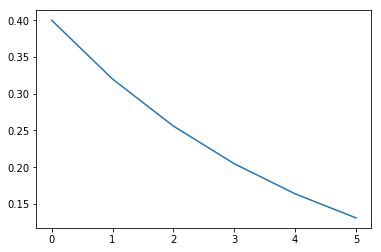

In [213]:
plt.plot(time, epsilon_values)
plt.show()